In [182]:
import numpy as np

def read_dvec(filename):
    """
    Reads the dipole vector matrix element data file in the QERaman code format.

    Parameters:
    filename (str): The name of the file to read.

    Returns:
    tuple: A tuple containing the following elements:
        - k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
        - wk (np.ndarray): An array of shape (nks,) containing the weights of the k-points.
        - eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues (in Rydbergs).
        - dvec (np.ndarray): A complex array of shape (nks, nbnd, nbnd, 3) containing the dipole vector matrix elements.
    """
    # Conversion factor from electron volts to Rydbergs
    ev2ry = 0.0734986176

    print("     Reading dipole vector matrix element data file")
    print("")

    # Open the file for reading
    with open(filename, 'r') as file:
        # Skip the initial dummy lines
        file.readline()
        file.readline()

        # Read the number of bands, occupied bands, and k-points
        nbnd, nbnd_occ, nks = map(int, file.readline().split())

        # Skip the remaining dummy lines
        file.readline()
        file.readline()
        file.readline()

        # Allocate arrays for k-points, weights, eigenvalues, and dipole vectors
        k = np.zeros((nks, 3))
        wk = np.zeros(nks)
        eigv = np.zeros((nks, nbnd))
        dvec = np.zeros((nks, nbnd, nbnd, 3), dtype=np.complex128)

        # Loop over each k-point
        for ik in range(nks):
            # Read the k-point vector and its weight
            line = file.readline().split()
            k[ik, :] = list(map(float, line[:3]))
            wk[ik] = float(line[3])

            # Loop over each pair of bands (final state and initial state)
            for ii in range(nbnd):
                for jj in range(nbnd):
                    # Read the data for the dipole matrix elements and eigenvalues
                    line = file.readline().split()
                    ribi = int(line[0])
                    ribf = int(line[1])
                    eigv_ik_ii = float(line[2])
                    eigv_ik_jj = float(line[3])
                    rdx_r = float(line[4])
                    rdx_i = float(line[5])
                    rdy_r = float(line[6])
                    rdy_i = float(line[7])
                    rdz_r = float(line[8])
                    rdz_i = float(line[9])

                    # Store the real and imaginary parts of the dipole vector components
                    dvec[ik, ii, jj, 0] = rdx_r + 1j * rdx_i  # D_x^(k,f,i)
                    dvec[ik, ii, jj, 1] = rdy_r + 1j * rdy_i  # D_y^(k,f,i)
                    dvec[ik, ii, jj, 2] = rdz_r + 1j * rdz_i  # D_z^(k,f,i)

                    # Store the eigenvalues
                    eigv[ik, ii] = eigv_ik_ii
                    eigv[ik, jj] = eigv_ik_jj

        # Convert eigenvalues from eV to Rydbergs
        #eigv *= ev2ry

    print("     Finished reading dipole vector matrix element")
    print("")

    return k, wk, eigv, dvec

def dispersion(filename):
    """
    Reads the dipole vector matrix element data file and returns the k-points and band energies.

    Parameters:
    filename (str): The name of the file to read.

    Returns:
    tuple: A tuple containing the following elements:
        - k_array (list of list): A list of k-point vectors.
        - bands (list of list): A list of lists, where each inner list contains the band energies for a specific band index.
    """
    # Read the data from the file using the read_dvec function
    k, wk, eigv, dvec = read_dvec(filename)

    # Convert the k-point array to a list of lists
    k_array = k.tolist()

    # Convert the eigenvalues array to a list of lists for each band index
    nbnd = eigv.shape[1]
    bands = [[] for _ in range(nbnd)]
    for ik in range(len(k)):
        for ib in range(nbnd):
            bands[ib].append(eigv[ik, ib])

    return k_array, bands

def compute_distances(k_points):
    """
    Computes the cumulative distances between consecutive k-points.

    Parameters:
    k_points (list of list): A list of k-point vectors.

    Returns:
    list: A list of cumulative distances.
    """
    distances = [0.0]
    for i in range(1, len(k_points)):
        distance = np.linalg.norm(np.array(k_points[i]) - np.array(k_points[i-1]))
        distances.append(distances[-1] + distance)
    return distances

def plot_band_structure(k_points, bands):
    """
    Plots the band structure.

    Parameters:
    k_points (list of list): A list of k-point vectors.
    bands (list of list): A list of lists, where each inner list contains the band energies for a specific band index.
    """
    # Compute cumulative distances for k-points
    distances = compute_distances(k_points)

    # Plot the band structure
    plt.figure(figsize=(10, 6))
    for band in bands:
        plt.plot(distances, band, color='b')
    plt.xlabel('k-point Distance')
    #plt.ylabel('Energy (Rydbergs)')
    plt.ylabel('E (eV)')
    plt.title('Band Structure')
    #plt.ylim(4, 10)
    plt.grid(True)
    plt.show()
    
def jdos(eigv, nbins=100):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands.

    Parameters:
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.
    nbins (int): Number of bins to use for the histogram.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are histograms of energy differences.
    """
    nks, nbnd = eigv.shape
    jdos_data = {}

    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            energy_diffs = np.abs(eigv[:, i] - eigv[:, j])
            hist, bin_edges = np.histogram(energy_diffs, bins=nbins, density=True)
            jdos_data[(i, j)] = (hist, bin_edges)

    return jdos_data

def plot_jdos(jdos_data):
    """
    Plots the JDOS for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are histograms of energy differences.
    """
    plt.figure(figsize=(12, 8))

    for (i, j), (hist, bin_edges) in jdos_data.items():
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, hist)#, label=f'Band {i}-{j}')

    plt.xlabel('Energy Difference (Rydbergs)')
    plt.ylabel('JDOS')
    plt.xlim(-3,3)
    plt.title('Joint Density of States (JDOS)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def compute_gradient(k, eigv):
    """
    Computes the gradient of the energy bands with respect to the k-points.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd, 3) containing the gradients of the eigenvalues.
    """
    nks, nbnd = eigv.shape
    grad_eigv = np.zeros((nks, nbnd, 3))
    for i in range(nbnd):
        for j in range(3):
            grad_eigv[:, i, j] = np.gradient(eigv[:, i], k[:, j])
    return grad_eigv

def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s
    eV_to_J = 1.60218e-19  # Conversion factor from eV to Joules

    nks, nbnd = eigv.shape
    grad_eigv = compute_gradient(k, eigv)

    jdos_data = {}
    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            delta_grad = np.linalg.norm(grad_eigv[:, i, :] - grad_eigv[:, j, :], axis=1)
            delta_E = np.abs(eigv[:, i] - eigv[:, j])
            factor = np.linalg.norm(k, axis=1)**2 / hbar**2  # Assuming a simple k-space distance, could be modified
            jdos_values = factor * delta_E / delta_grad
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data

def plot_jdos(jdos_data, k):
    """
    Plots the JDOS as a function of k for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    """
    plt.figure(figsize=(12, 8))

    for (i, j), jdos_values in jdos_data.items():
        k_norm = np.linalg.norm(k, axis=1)
        plt.plot(k_norm, jdos_values, label=f'Band {i}-{j}')

    plt.xlabel('k')
    plt.ylabel('JDOS')
    plt.title('Joint Density of States (JDOS) as a function of k')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def compute_gradient(k, eigv):
    """
    Computes the gradient of the energy bands with respect to the k-points.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd, 3) containing the gradients of the eigenvalues.
    """
    nks, nbnd = eigv.shape
    grad_eigv = np.zeros((nks, nbnd, 3))
    for i in range(nbnd):
        for j in range(3):
            grad_eigv[:, i, j] = np.gradient(eigv[:, i], k[:, j])
    return grad_eigv

def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s
    eV_to_J = 1.60218e-19  # Conversion factor from eV to Joules

    nks, nbnd = eigv.shape
    grad_eigv = compute_gradient(k, eigv)

    jdos_data = {}
    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            delta_grad = np.linalg.norm(grad_eigv[:, i, :] - grad_eigv[:, j, :], axis=1)
            delta_E = np.abs(eigv[:, i] - eigv[:, j])
            factor = np.linalg.norm(k, axis=1)**2 / hbar**2  # Assuming a simple k-space distance, could be modified
            jdos_values = factor * delta_E / delta_grad
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data

def plot_jdos(jdos_data, k):
    """
    Plots the JDOS as a function of k for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    """
    plt.figure(figsize=(12, 8))

    for (i, j), jdos_values in jdos_data.items():
        k_norm = np.linalg.norm(k, axis=1)
        plt.plot(k_norm, jdos_values, label=f'Band {i}-{j}')

    plt.xlabel('k')
    plt.ylabel('JDOS')
    plt.title('Joint Density of States (JDOS) as a function of k')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def compute_gradient(k, eigv):
    """
    Computes the gradient of the energy bands with respect to the k-points.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd, 3) containing the gradients of the eigenvalues.
    """
    nks, nbnd = eigv.shape
    grad_eigv = np.zeros((nks, nbnd, 3))
    for i in range(nbnd):
        for j in range(3):
            grad_eigv[:, i, j] = np.gradient(eigv[:, i], k[:, j])
    return grad_eigv

def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s
    eV_to_J = 1.60218e-19  # Conversion factor from eV to Joules

    nks, nbnd = eigv.shape
    eigv = eV_to_J * eigv
    grad_eigv = compute_gradient(k, eigv)
    jdos_data = {}
    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            delta_grad = np.linalg.norm(grad_eigv[:, i, :] - grad_eigv[:, j, :], axis=1)
            delta_E = np.abs(eigv[:, i] - eigv[:, j])
            distances = np.array(compute_distances(k))
            factor = distances**2 /hbar**2
            #factor = np.linalg.norm(k, axis=1)**2 / hbar**2  # Assuming a simple k-space distance, could be modified
            jdos_values = factor/delta_grad
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



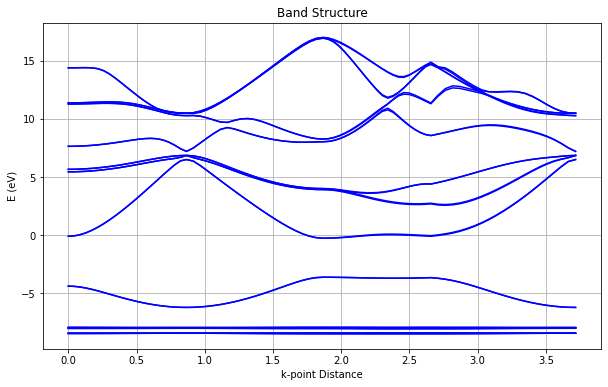

In [167]:
# Example usage
filename = 'GaAs.dvec'
k_array, bands = dispersion(filename)
plot_band_structure(k_array, bands)


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



No handles with labels found to put in legend.


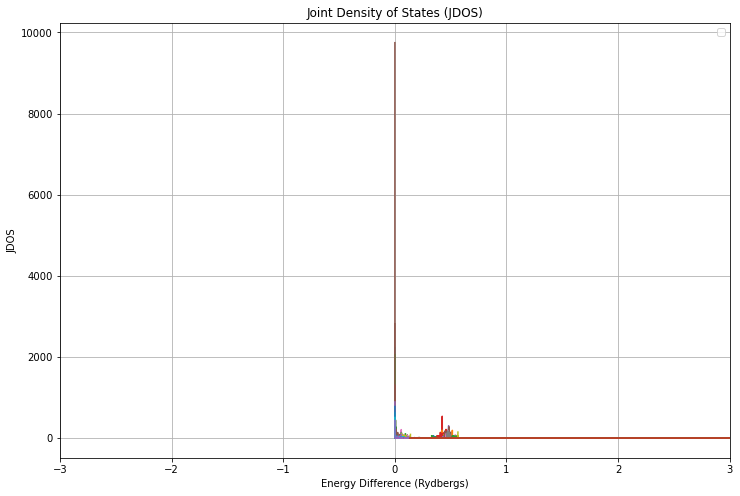

In [113]:
# Example usage
filename = 'GaAs.dvec'
k, wk, eigv, dvec = read_dvec(filename)
jdos_data = jdos(eigv)
plot_jdos(jdos_data)


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in di

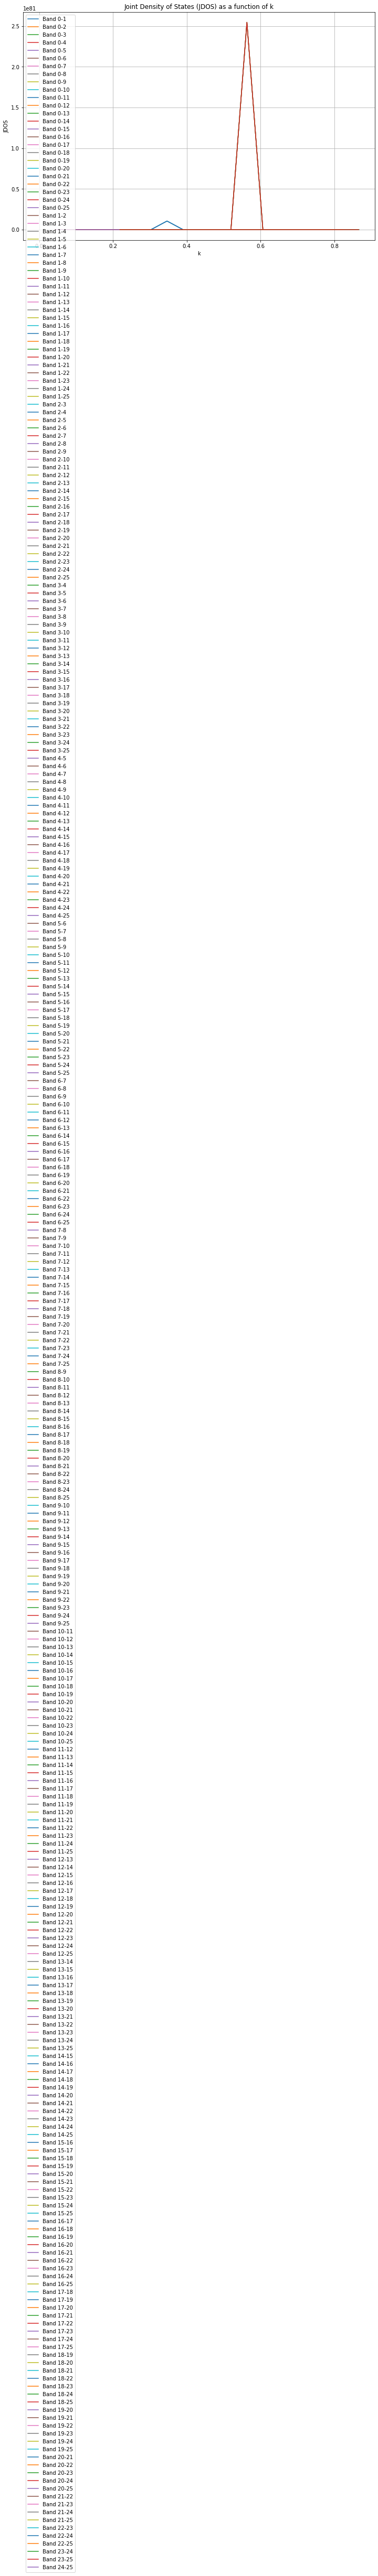

In [114]:
# Example usage
filename = 'GaAs.dvec'
k, wk, eigv, dvec = read_dvec(filename)
jdos_data = jdos(k, eigv)
plot_jdos(jdos_data, k)


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



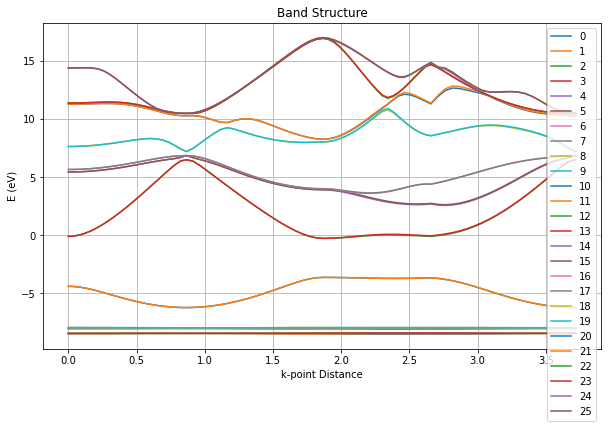

No handles with labels found to put in legend.


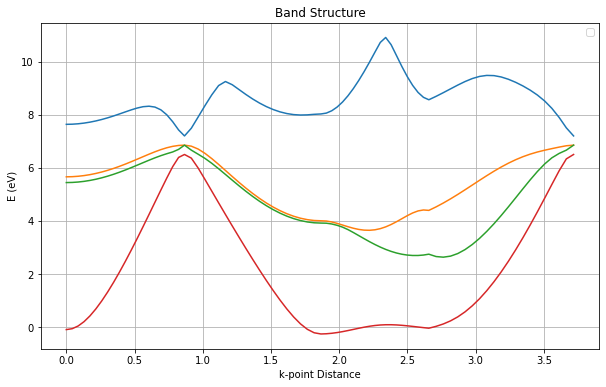

In [148]:
def plot_band_structure(k_points, bands):
    """
    Plots the band structure.

    Parameters:
    k_points (list of list): A list of k-point vectors.
    bands (list of list): A list of lists, where each inner list contains the band energies for a specific band index.
    """
    # Compute cumulative distances for k-points
    distances = compute_distances(k_points)

    # Plot the band structure
    plt.figure(figsize=(10, 6))
    for i in range(len(bands)):
        plt.plot(distances, bands[i], label = f'{i}')
    plt.xlabel('k-point Distance')
    #plt.ylabel('Energy (Rydbergs)')
    plt.ylabel('E (eV)')
    plt.title('Band Structure')
    #plt.ylim(4, 10)
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Example usage
filename = 'GaAs.dvec'
k_array, bands = dispersion(filename)
plot_band_structure(k_array, bands)

def plot_band_structure(k_points, bands):
    """
    Plots the band structure.

    Parameters:
    k_points (list of list): A list of k-point vectors.
    bands (list of list): A list of lists, where each inner list contains the band energies for a specific band index.
    """
    # Compute cumulative distances for k-points
    distances = compute_distances(k_points)

    # Plot the band structure
    plt.figure(figsize=(10, 6))
    plt.plot(distances, bands[19])
    plt.plot(distances, bands[17])
    plt.plot(distances, bands[15])
    plt.plot(distances, bands[13])
    plt.xlabel('k-point Distance')
    #plt.ylabel('Energy (Rydbergs)')
    plt.ylabel('E (eV)')
    plt.title('Band Structure')
    #plt.ylim(4, 10)
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_band_structure(k_array, bands)

     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/mohan/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: invalid value encountered in di

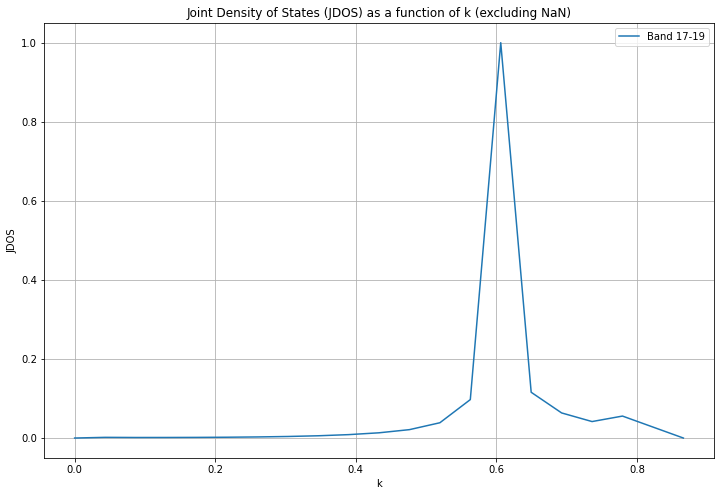

In [170]:



def plot_jdos(jdos_data, k):
  """
  Plots the JDOS as a function of k for each pair of bands, excluding NaN values.

  Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
  """

  plt.figure(figsize=(12, 8))
  k_norm = np.linalg.norm(k, axis=1)

  # Filter k and jdos_data for non-NaN values
  valid_k = k_norm[~np.isnan(jdos_data[(17, 19)])]
  valid_jdos = jdos_data[(17, 19)][~np.isnan(jdos_data[(17, 19)])]
  valid_jdos = valid_jdos/max(valid_jdos)
  # Plot the filtered data
  plt.plot(valid_k, valid_jdos, label=f'Band {17}-{19}')

  plt.xlabel('k')
  plt.ylabel('JDOS')
  plt.title('Joint Density of States (JDOS) as a function of k (excluding NaN)')
  plt.legend()
  plt.grid(True)
  plt.show()


# Example usage
filename = 'GaAs.dvec'
k, wk, eigv, dvec = read_dvec(filename)
jdos_data = jdos(k, eigv)
plot_jdos(jdos_data, k)

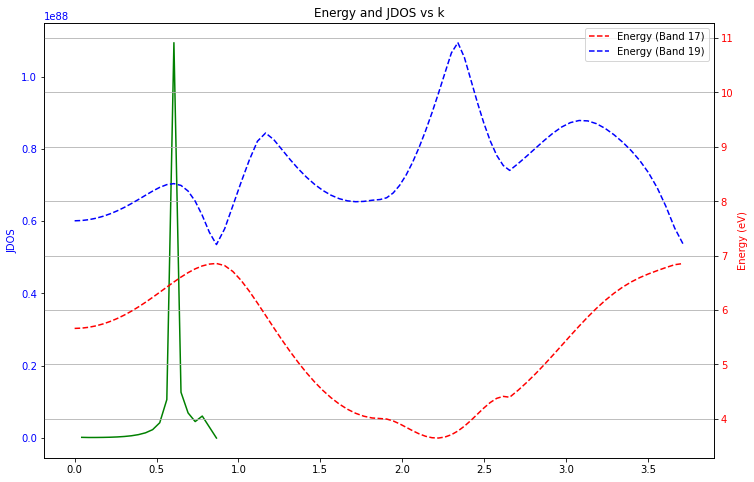

In [171]:
import matplotlib.pyplot as plt
import numpy as np

def plot_energy_jdos(energy_data, jdos_data, k, band_index_i, band_index_f):
  """
  Plots energy and JDOS vs k in the same figure with separate axes.

  Parameters:
    energy_data (dict): A dictionary where keys are band indices and values are energy values at each k-point.
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    band_index (int): The band index for which to plot energy.
  """

  plt.figure(figsize=(12, 8))
  k_norm = np.linalg.norm(k, axis=1)

  # Create twin axes for energy and JDOS
  ax1 = plt.gca()  # Get current main axes
  ax2 = ax1.twinx()  # Create a twin axes that shares the x-axis
  distances = compute_distances(k)
  # Plot energy on the right axis (ax2)
  ax2.plot(distances, energy_data[band_index_i], 'r--', label=f'Energy (Band {band_index_i})')
  ax2.plot(distances, energy_data[band_index_f], 'b--', label=f'Energy (Band {band_index_f})')
  ax2.set_ylabel('Energy (eV)', color='r')
  ax2.tick_params(axis='y', labelcolor='r')

  # Plot JDOS on the left axis (ax1)
  ax1.plot(k_norm, jdos_data[(band_index_i, band_index_f)], 'g', label=f'JDOS (Band {band_index_i}-{band_index_f})')
  ax1.set_ylabel('JDOS', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  # Common labels and title
  plt.xlabel('k')
  plt.title('Energy and JDOS vs k')
  plt.legend()
  plt.grid(True)
  plt.show()
    
energy_data = bands
plot_energy_jdos(energy_data, jdos_data, k_array, 17, 19)

     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/508766924.py:108: RuntimeWarning: invalid value encountered in subtract
  delta_grad = np.linalg.norm(grad_eigv[:, i, :] - grad_eigv[:, j, :], axis=1)
/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/508766924.py:111: RuntimeWarning: divide by zero encountered in divide
  jdos_values = factor / delta_grad
No handles with labels found to put in legend.


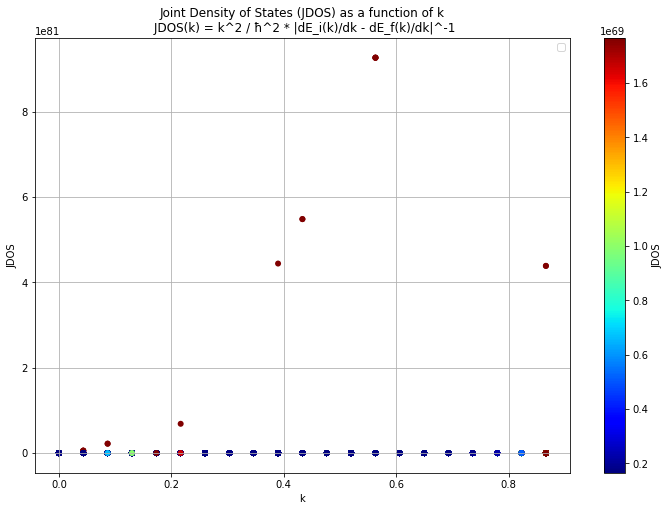

In [174]:
import numpy as np
import matplotlib.pyplot as plt

def read_dvec(filename):
    """
    Reads the dipole vector matrix element data file in the QERaman code format.

    Parameters:
    filename (str): The name of the file to read.

    Returns:
    tuple: A tuple containing the following elements:
        - k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
        - eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues (in Rydbergs).
        - dvec (np.ndarray): A complex array of shape (nks, nbnd, nbnd, 3) containing the dipole vector matrix elements.
    """
    ev2ry = 0.0734986176

    print("     Reading dipole vector matrix element data file")
    print("")

    with open(filename, 'r') as file:
        file.readline()
        file.readline()
        nbnd, nbnd_occ, nks = map(int, file.readline().split())
        file.readline()
        file.readline()
        file.readline()

        k = np.zeros((nks, 3))
        eigv = np.zeros((nks, nbnd))
        dvec = np.zeros((nks, nbnd, nbnd, 3), dtype=np.complex128)

        for ik in range(nks):
            line = file.readline().split()
            k[ik, :] = list(map(float, line[:3]))
            wk = float(line[3])

            for ii in range(nbnd):
                for jj in range(nbnd):
                    line = file.readline().split()
                    ribi = int(line[0])
                    ribf = int(line[1])
                    eigv_ik_ii = float(line[2])
                    eigv_ik_jj = float(line[3])
                    rdx_r = float(line[4])
                    rdx_i = float(line[5])
                    rdy_r = float(line[6])
                    rdy_i = float(line[7])
                    rdz_r = float(line[8])
                    rdz_i = float(line[9])

                    dvec[ik, ii, jj, 0] = rdx_r + 1j * rdx_i
                    dvec[ik, ii, jj, 1] = rdy_r + 1j * rdy_i
                    dvec[ik, ii, jj, 2] = rdz_r + 1j * rdz_i

                    if jj == 0:
                        eigv[ik, ii] = eigv_ik_ii

        eigv *= ev2ry

    print("     Finished reading dipole vector matrix element")
    print("")

    return k, eigv, dvec

def compute_gradient(k, eigv):
    """
    Computes the gradient of the energy bands with respect to the k-points.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd, 3) containing the gradients of the eigenvalues.
    """
    nks, nbnd = eigv.shape
    grad_eigv = np.zeros((nks, nbnd, 3))
    for i in range(nbnd):
        for j in range(3):
            grad_eigv[:, i, j] = np.gradient(eigv[:, i], k[:, j])
    return grad_eigv

def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.

    JDOS Calculation Formula:
    JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s
    eV_to_J = 1.60218e-19  # Conversion factor from eV to Joules

    nks, nbnd = eigv.shape
    grad_eigv = compute_gradient(k, eigv)

    jdos_data = {}
    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            delta_grad = np.linalg.norm(grad_eigv[:, i, :] - grad_eigv[:, j, :], axis=1)
            delta_E = np.abs(eigv[:, i] - eigv[:, j])
            factor = np.linalg.norm(k, axis=1)**2 / hbar**2  # Assuming a simple k-space distance, could be modified
            jdos_values = factor * delta_E/ delta_grad
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data

def plot_jdos(jdos_data, k):
    """
    Plots the JDOS as a function of k for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    """
    plt.figure(figsize=(12, 8))

    k_norm = np.linalg.norm(k, axis=1)

    for (i, j), jdos_values in jdos_data.items():
        plt.scatter(k_norm, jdos_values, c=jdos_values, cmap='jet', edgecolor='none')#, label=f'Band {i}-{j}')

    plt.colorbar(label='JDOS')
    plt.xlabel('k')
    plt.ylabel('JDOS')
    plt.title('Joint Density of States (JDOS) as a function of k\n JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
filename = 'GaAs.dvec'
k, eigv, dvec = read_dvec(filename)
jdos_data = jdos(k, eigv)
plot_jdos(jdos_data, k)


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/2163520514.py:46: RuntimeWarning: divide by zero encountered in divide
  jdos_values = factor / delta_grad_magnitude
/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/2163520514.py:46: RuntimeWarning: invalid value encountered in divide
  jdos_values = factor / delta_grad_magnitude


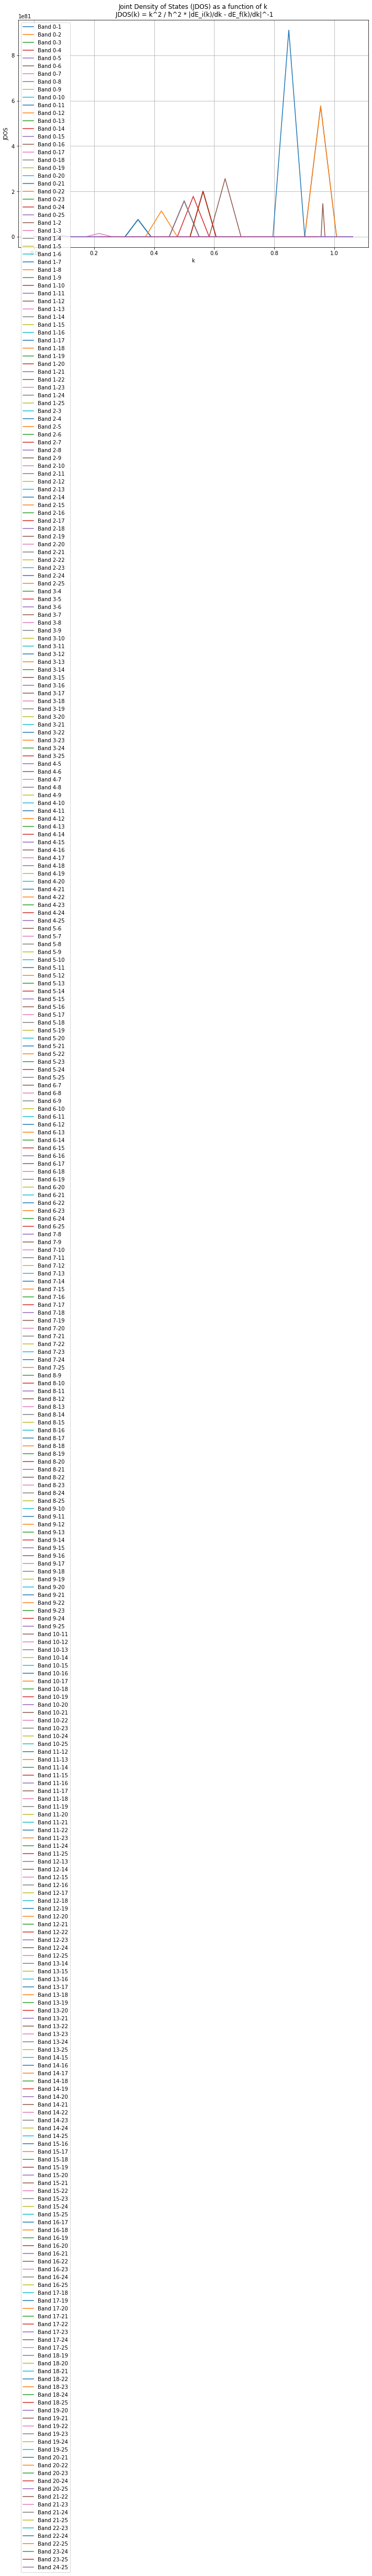

In [189]:
def compute_gradient_magnitude(k, eigv):
    """
    Computes the gradient of the energy bands with respect to the magnitude of k-points.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd) containing the gradients of the eigenvalues with respect to |k|.
    """
    k_magnitude = np.linalg.norm(k, axis=1)
    grad_eigv_magnitude = np.zeros_like(eigv)

    for i in range(eigv.shape[1]):
        grad_eigv_magnitude[:, i] = np.gradient(eigv[:, i], k_magnitude)

    return grad_eigv_magnitude

def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.

    JDOS Calculation Formula:
    JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s

    nks, nbnd = eigv.shape
    grad_eigv_magnitude = compute_gradient_magnitude(k, eigv)

    k_magnitude = np.linalg.norm(k, axis=1)
    factor = k_magnitude**2 / hbar**2

    jdos_data = {}
    for i in range(nbnd):
        for j in range(i + 1, nbnd):
            delta_grad_magnitude = np.abs(grad_eigv_magnitude[:, i] - grad_eigv_magnitude[:, j])
            jdos_values = factor / delta_grad_magnitude
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data

def plot_jdos(jdos_data, k):
    """
    Plots the JDOS as a function of k for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    """
    plt.figure(figsize=(12, 8))

    k_norm = np.linalg.norm(k, axis=1)

    for (i, j), jdos_values in jdos_data.items():
        plt.plot(k_norm, jdos_values, label=f'Band {i}-{j}')

    #plt.colorbar(label='JDOS')
    plt.xlabel('k')
    plt.ylabel('JDOS')
    plt.title('Joint Density of States (JDOS) as a function of k\n JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Example usage
filename = 'GaAs.dvec'
k, wk, eigv, dvec = read_dvec(filename)
jdos_data = jdos(k, eigv)
plot_jdos(jdos_data, k)

     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/2163520514.py:46: RuntimeWarning: divide by zero encountered in divide
  jdos_values = factor / delta_grad_magnitude


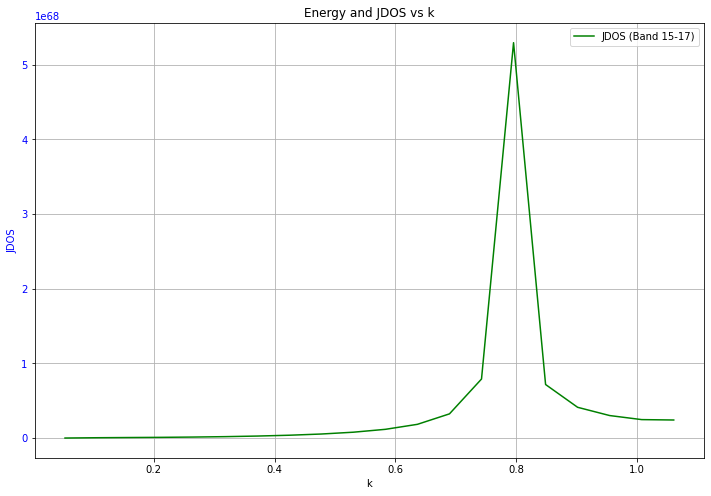

In [209]:
def plot_energy_jdos(jdos_data, k, band_index_i, band_index_f):
    
  plt.figure(figsize=(12, 8))
  k_norm = np.linalg.norm(k, axis=1)

  # Create twin axes for energy and JDOS
  ax1 = plt.gca()  # Get current main axes

  # Plot JDOS on the left axis (ax1)
  ax1.plot(k_norm, jdos_data[(band_index_i, band_index_f)], 'g-', label=f'JDOS (Band {band_index_i}-{band_index_f})')
  ax1.set_ylabel('JDOS', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  # Common labels and title
  plt.xlabel('k')
  plt.title('Energy and JDOS vs k')
  plt.legend()
  plt.grid(True)
  plt.show()

filename = 'GaAs.dvec'
k, wk, eigv, dvec = read_dvec(filename)

starting = 60
ending = 80
jdos_data = jdos(k[starting:ending], eigv[starting:ending])
plot_energy_jdos(jdos_data, k[starting:ending], 15, 17)

In [207]:
k[starting:ending]

array([[-0.9875,  0.0375,  0.    ],
       [-0.975 ,  0.075 ,  0.    ],
       [-0.9625,  0.1125,  0.    ],
       [-0.95  ,  0.15  ,  0.    ],
       [-0.9375,  0.1875,  0.    ],
       [-0.925 ,  0.225 ,  0.    ],
       [-0.9125,  0.2625,  0.    ],
       [-0.9   ,  0.3   ,  0.    ],
       [-0.8875,  0.3375,  0.    ],
       [-0.875 ,  0.375 ,  0.    ],
       [-0.8625,  0.4125,  0.    ],
       [-0.85  ,  0.45  ,  0.    ],
       [-0.8375,  0.4875,  0.    ],
       [-0.825 ,  0.525 ,  0.    ],
       [-0.8125,  0.5625,  0.    ],
       [-0.8   ,  0.6   ,  0.    ],
       [-0.7875,  0.6375,  0.    ],
       [-0.775 ,  0.675 ,  0.    ],
       [-0.7625,  0.7125,  0.    ]])

In [208]:
k

array([[-0.5   ,  0.5   ,  0.5   ],
       [-0.475 ,  0.475 ,  0.475 ],
       [-0.45  ,  0.45  ,  0.45  ],
       [-0.425 ,  0.425 ,  0.425 ],
       [-0.4   ,  0.4   ,  0.4   ],
       [-0.375 ,  0.375 ,  0.375 ],
       [-0.35  ,  0.35  ,  0.35  ],
       [-0.325 ,  0.325 ,  0.325 ],
       [-0.3   ,  0.3   ,  0.3   ],
       [-0.275 ,  0.275 ,  0.275 ],
       [-0.25  ,  0.25  ,  0.25  ],
       [-0.225 ,  0.225 ,  0.225 ],
       [-0.2   ,  0.2   ,  0.2   ],
       [-0.175 ,  0.175 ,  0.175 ],
       [-0.15  ,  0.15  ,  0.15  ],
       [-0.125 ,  0.125 ,  0.125 ],
       [-0.1   ,  0.1   ,  0.1   ],
       [-0.075 ,  0.075 ,  0.075 ],
       [-0.05  ,  0.05  ,  0.05  ],
       [-0.025 ,  0.025 ,  0.025 ],
       [ 0.    ,  0.    ,  0.    ],
       [-0.05  ,  0.    ,  0.    ],
       [-0.1   ,  0.    ,  0.    ],
       [-0.15  ,  0.    ,  0.    ],
       [-0.2   ,  0.    ,  0.    ],
       [-0.25  ,  0.    ,  0.    ],
       [-0.3   ,  0.    ,  0.    ],
       [-0.35  ,  0.    ,  0

     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/2965769622.py:58: RuntimeWarning: divide by zero encountered in divide
  jdos_values = factor / delta_grad
/var/folders/qb/2nb3dxks3p38pv8jbwg013380000gn/T/ipykernel_80837/2965769622.py:58: RuntimeWarning: invalid value encountered in divide
  jdos_values = factor / delta_grad


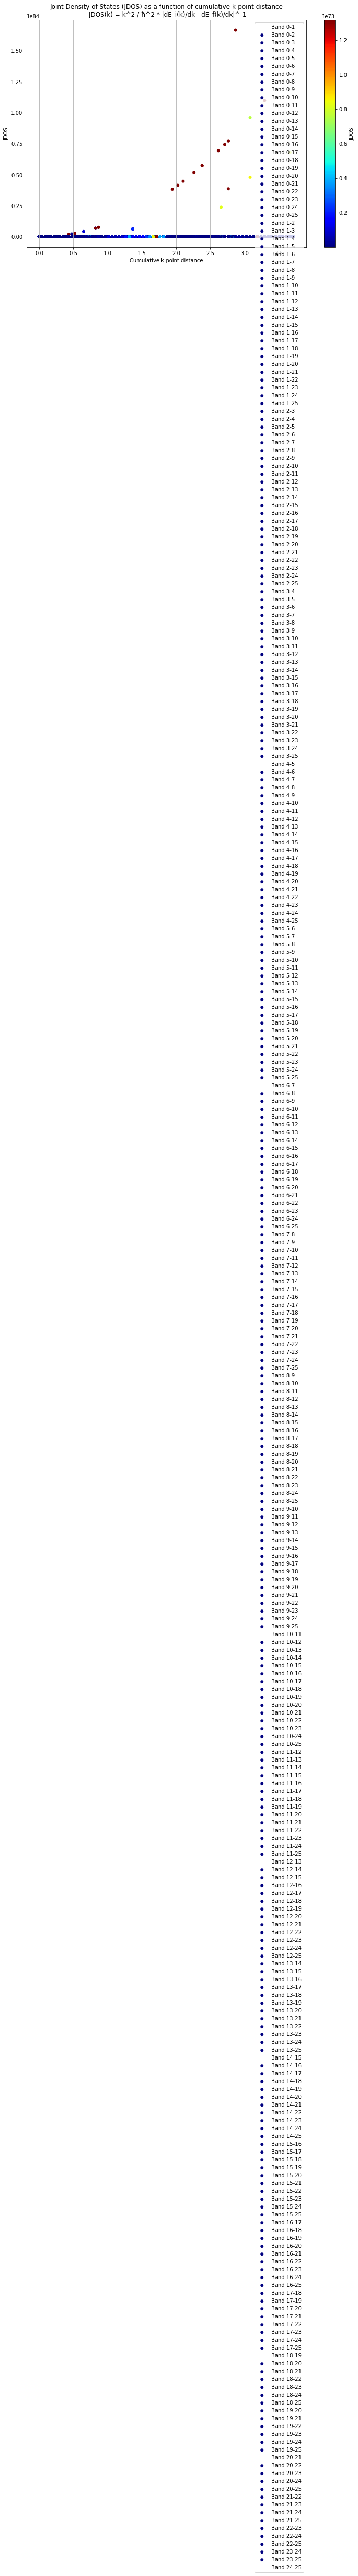

In [180]:
def compute_distances(k_points):
    """
    Computes the cumulative distances between consecutive k-points.

    Parameters:
    k_points (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.

    Returns:
    np.ndarray: An array of cumulative distances.
    """
    distances = np.zeros(len(k_points))
    for i in range(1, len(k_points)):
        distances[i] = distances[i-1] + np.linalg.norm(k_points[i] - k_points[i-1])
    return distances
def compute_gradient(distances, eigv):
    """
    Computes the gradient of the energy bands with respect to the cumulative k-point distances.

    Parameters:
    distances (np.ndarray): An array of cumulative distances between k-points.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    np.ndarray: An array of shape (nks, nbnd) containing the gradients of the eigenvalues with respect to cumulative distances.
    """
    nks, nbnd = eigv.shape
    grad_eigv = np.zeros_like(eigv)

    for i in range(nbnd):
        grad_eigv[:, i] = np.gradient(eigv[:, i], distances)
    
    return grad_eigv
def jdos(k, eigv):
    """
    Calculates the Joint Density of States (JDOS) between each pair of bands as a function of k.

    Parameters:
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    eigv (np.ndarray): An array of shape (nks, nbnd) containing the eigenvalues.

    Returns:
    dict: A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.

    JDOS Calculation Formula:
    JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1
    """
    hbar = 1.0545718e-34  # Planck constant over 2*pi in J.s

    distances = compute_distances(k)
    grad_eigv = compute_gradient(distances, eigv)

    factor = distances**2 / hbar**2

    jdos_data = {}
    for i in range(eigv.shape[1]):
        for j in range(i + 1, eigv.shape[1]):
            delta_grad = np.abs(grad_eigv[:, i] - grad_eigv[:, j])
            jdos_values = factor / delta_grad
            jdos_data[(i, j)] = jdos_values
    
    return jdos_data, distances
def plot_jdos(jdos_data, distances):
    """
    Plots the JDOS as a function of k for each pair of bands.

    Parameters:
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    distances (np.ndarray): An array of cumulative distances between k-points.
    """
    plt.figure(figsize=(12, 8))

    for (i, j), jdos_values in jdos_data.items():
        plt.scatter(distances, jdos_values, c=jdos_values, cmap='jet', label=f'Band {i}-{j}', edgecolor='none')

    plt.colorbar(label='JDOS')
    plt.xlabel('Cumulative k-point distance')
    plt.ylabel('JDOS')
    plt.title('Joint Density of States (JDOS) as a function of cumulative k-point distance\n JDOS(k) = k^2 / ħ^2 * |dE_i(k)/dk - dE_f(k)/dk|^-1')
    plt.legend()
    plt.grid(True)
    plt.show()
filename = 'GaAs.dvec'
k, eigv, dvec = read_dvec(filename)
jdos_data, distances = jdos(k, eigv)
plot_jdos(jdos_data, distances)


     Reading dipole vector matrix element data file

     Finished reading dipole vector matrix element



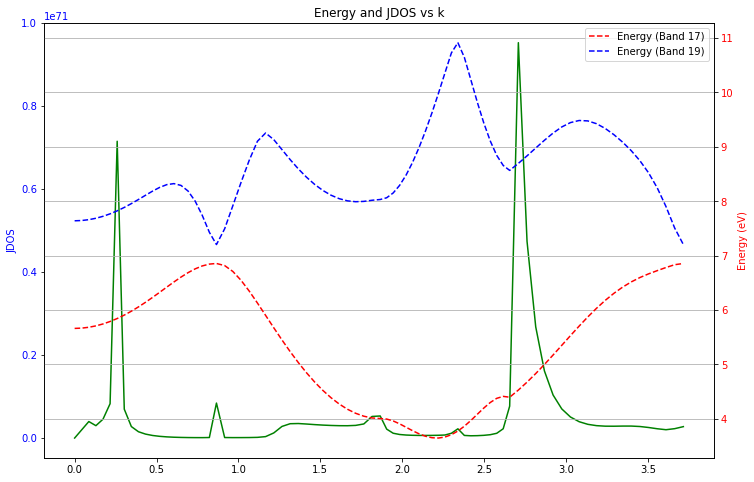

In [184]:
def plot_energy_jdos(energy_data, jdos_data, k, band_index_i, band_index_f):
  """
  Plots energy and JDOS vs k in the same figure with separate axes.

  Parameters:
    energy_data (dict): A dictionary where keys are band indices and values are energy values at each k-point.
    jdos_data (dict): A dictionary where keys are band pairs (i, j) and values are JDOS values at each k-point.
    k (np.ndarray): An array of shape (nks, 3) containing the k-point vectors.
    band_index (int): The band index for which to plot energy.
  """

  plt.figure(figsize=(12, 8))
  k_norm = np.linalg.norm(k, axis=1)

  # Create twin axes for energy and JDOS
  ax1 = plt.gca()  # Get current main axes
  ax2 = ax1.twinx()  # Create a twin axes that shares the x-axis
  distances = compute_distances(k)
  # Plot energy on the right axis (ax2)
  ax2.plot(distances, energy_data[band_index_i], 'r--', label=f'Energy (Band {band_index_i})')
  ax2.plot(distances, energy_data[band_index_f], 'b--', label=f'Energy (Band {band_index_f})')
  ax2.set_ylabel('Energy (eV)', color='r')
  ax2.tick_params(axis='y', labelcolor='r')

  # Plot JDOS on the left axis (ax1)
  ax1.plot(distances, jdos_data[(band_index_i, band_index_f)], 'g', label=f'JDOS (Band {band_index_i}-{band_index_f})')
  ax1.set_ylabel('JDOS', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  # Common labels and title
  plt.xlabel('k')
  plt.title('Energy and JDOS vs k')
  plt.legend()
  plt.grid(True)
  plt.show()

k_array, bands = dispersion(filename)
energy_data = bands
plot_energy_jdos(energy_data, jdos_data, k_array, 17, 19)